# Portfolio Optimization using Python 

In [1]:
# Libraries 
import pathlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.optimize as sci_opt
from pprint import pprint # A print library!
from sklearn.preprocessing import StandardScaler

# Libraries to download data
from fake_useragent import UserAgent # :o
from data_downloader.data_client import PriceHistory 

# Set display options for Pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

## Getting the data

In [2]:
# Define symbols
symbols = ['AAPL','KO','SBUX','AXP'] # My stocks at 6/9/2024 :)
number_of_symbols = len(symbols)

# If we don't have data grab it from the NASDAQ
if not pathlib.Path('data/stock_data.csv').exists():

    # Initialize the PriceHistory Client.
    price_history_client = PriceHistory(symbols=symbols,
                                        user_agent=UserAgent().chrome,
                                        
                                        )

    # Grab the data and dump it to a CSV file
    price_history_client.price_data_frame.to_csv('data/stock_data.csv',
                                                 index=False
                                                 )
    display(price_history_client.price_data_frame)

    # Grab the data frame
    price_data_frame : pd.DataFrame = price_history_client.price_data_frame
else:
    # Load the existing csv file.
    price_data_frame : pd.DataFrame = pd.read_csv('data/stock_data.csv')

print(price_data_frame.head())

         date   close   volume    open      high       low symbol
0  2024-06-07  232.67  2212477  232.41  234.1205  231.7100    AXP
1  2024-06-06  233.35  2709843  234.79  236.4000  232.7000    AXP
2  2024-06-05  234.69  2925098  236.25  237.7000  233.7000    AXP
3  2024-06-04  237.25  2512117  236.39  240.0000  235.7300    AXP
4  2024-06-03  236.88  2677196  240.18  241.3600  233.5309    AXP


In [3]:
# We want one column for each stock, so we need to reorganize the dataframe.
price_data_frame = price_data_frame[['date','symbol','close']]

# Symbols are headers
price_data_frame = price_data_frame.pivot(index='date',
                                          columns='symbol',
                                          values='close'
                                          )
display(price_data_frame)

symbol,AAPL,AXP,KO,SBUX
date,,,,
2023-12-11,193.18,168.39,59.04,98.12
2023-12-12,194.71,171.04,59.42,98.15
2023-12-13,197.96,174.56,59.93,98.11
2023-12-14,198.11,178.86,59.04,97.84
2023-12-15,197.57,180.51,58.60,96.75
...,...,...,...,...
2024-06-03,194.03,236.88,62.93,82.08
2024-06-04,194.35,237.25,63.94,82.79
2024-06-05,195.87,234.69,63.92,81.16


## Calculating Sharpe Ratio

We're using the portfolio of stocks to generate returns. To generate returns, we need to take on **risk**, but ideally we should be comfortable taking on this risk because we are compensated in the form returns that increase our investment.

Most investors aren't okay with taking on high levels of risk. Out goal is to find the best ratio risk vs. returns. Ideally, we are taking the most risk we are comfortable with and attempting to maximize those returns. 

***How do we measure risk?***

There are many ways to measure risk, and some are more appropiate than others depending on the situation at hand. In our case, we'll use a very popular metric, the _Sharpe Ratio_. The Sharpe Ratio is a measure for calculating risk-adjusted return and has been the industry standard for such caculations. It allows us to quentify the relationship between the average return earned in excess of the risk-free rate per unit of volatility or total risk. 

Mathematically, we define the Sharpe Ratio as the following: 

$$ \text{Sharpe Ratio} = \frac{R_p-R_f}{\sigma_p},$$

where:
- $R_p$: Return of Portfolio
- $R_f$: Risk-free rate
- $\sigma_p$: Standard-Deviation of Portfolio's Excess returns.
  
  To calculate the expected returns, we use the following formula:
  $$R_p = \sum_i^S w_ir_i,$$

  where
  - $r_i$: Return of security $i$
  - $w_i$: Weight of security $i$
  
  To calculate the standard deviation of the portfolio, we use the following formula:
  $$\sigma_p = \sqrt{\sum_i^S w_i^2\sigma_i^2 +\sum_{i,j}^S 2w_iw_jp_{ij}\sigma_i\sigma_j},$$
where
- $p_{ij}$: Correlation coefficient between the return of assets $i,j$.



## Montecarlo simulations

In [26]:
# Calculate the log returns
log_return = np.log(1 + price_data_frame.pct_change())
# Generate random weights
random_weights = np.random.random(number_of_symbols)
rebalance_weights = random_weights/np.sum(random_weights)
# Calculate the Expected Returns, annualize it by multiplying it by 252
exp_ret = np.sum((log_return.mean() * rebalance_weights)*252)
# Annualized Expected Volatility
exp_vol = np.sqrt(
    np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov()*252,
        rebalance_weights
    ) 
)
                  )

# Calculate Sharpe Ratio
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better
weights_df = pd.DataFrame(
    data={
        'random_weights': random_weights,
        'rebalance_weights': rebalance_weights
    }
)

print('')
print('='*80)
print("Portfolio Weights:")
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics
metrics_df = pd.DataFrame(
    data={
        'Expected Portfolio Returns': exp_ret,
        'Expected Portofolio Volatility': exp_vol,
        'Portfolio Sharpe Ratio':sharpe_ratio,
    },
    index=[0]
)
print('')
print('='*80)
print("Portfolio Metrics:")
print('-'*80)
print(metrics_df)
print('-'*80)


Portfolio Weights:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.225456           0.295587
1        0.209554           0.274740
2        0.325074           0.426194
3        0.002654           0.003479
--------------------------------------------------------------------------------

Portfolio Metrics:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portofolio Volatility  Portfolio Sharpe Ratio
0                    0.261401                        0.114726                2.278477
--------------------------------------------------------------------------------


## Portfolio Optimization: Monte Carlo

If we know that we want to get a higher Sharpe Ratio, what is the portfolio allocation we need to achieve this?
- First, we could test a bunch of different random allocations and see which ones produces the highest Sharpe Ratio. 
- Second, we could use mathematical optimization defined by some constraints to arrive at the optimal allocation. 

The first option is formally known as a Monte Carlo simulation.

In [30]:
# We will run 10_000 iterations
number_of_iterations = 10_000

# Prep an array to store the weights, and metrics as they are generated, 10_000 for each of our 4 stocks
all_weights = np.zeros((number_of_iterations,number_of_symbols))
ret_arr = np.zeros(number_of_iterations)
vol_arr = np.zeros(number_of_iterations)
sharpe_arr = np.zeros(number_of_iterations)

for ind in range(number_of_iterations):
    weights = np.random.random(number_of_symbols)
    weights /= np.sum(weights)

    all_weights[ind,:] = weights

    # Calculate expected log returns
    ret_arr[ind] = np.sum((log_return.mean()*weights)*252)
    # Calculate volatility
    vol_arr[ind] = np.sqrt(
        np.dot(
            weights.T,
            np.dot(log_return.cov()*252,
                    weights)
            )
    )
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [31]:
# Master Data frame with the results of the simulations
simulations_data = [ret_arr,vol_arr,sharpe_arr,all_weights]
simulations_df = pd.DataFrame(data=simulations_data).T

simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                     Portfolio Weights
0  0.179672    0.122610      1.465393   [0.34525296995849303, 0.24051228739225985, 0.3033243699588472, 0.11091037269039995]
1  0.049430    0.147130      0.335959  [0.12310563203696305, 0.18306183564706816, 0.34608257814393545, 0.34774995417203336]
2  0.178491    0.143439      1.244369   [0.34494525658422326, 0.3409642952515145, 0.10866612338664054, 0.20542432477762182]
3  0.031501    0.141652      0.222383   [0.46332075266446043, 0.08000766648396088, 0.24778158728533684, 0.2088899935662417]
4  0.029659    0.142720      0.207811   [0.39562514172131963, 0.11195795263096482, 0.23544635884652454, 0.2569705468011911]
--------------------------------------------------------------------------------


- We can take a look at the max Sharpe Ratio.
- The next metric is the portofolio with the minimum volatility.

In [35]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*120)
print('MAX SHARPE RATIO:')
print('-'*120)
print(max_sharpe_ratio)
print('-'*120)

print('')
print('='*120)
print('MIN VOLATILITY:')
print('-'*120)
print(min_volatility)
print('-'*120)


MAX SHARPE RATIO:
------------------------------------------------------------------------------------------------------------------------
Returns                                                                                            0.604522
Volatility                                                                                         0.194769
Sharpe Ratio                                                                                       3.103796
Portfolio Weights    [0.0038812326599070583, 0.8871799215818872, 0.10704493612357102, 0.001893909634634738]
Name: 5042, dtype: object
------------------------------------------------------------------------------------------------------------------------

MIN VOLATILITY:
------------------------------------------------------------------------------------------------------------------------
Returns                                                                                         0.209477
Volatility                            

C:\Users\Nico\AppData\Local\Temp\ipykernel_12792\3273976022.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\Nico\AppData\Local\Temp\ipykernel_12792\3273976022.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\Nico\AppData\Local\Temp\ipykernel_12792\3273976022.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_volatility[1],
C:\Users\Nico\AppData\Local\Temp\ipy

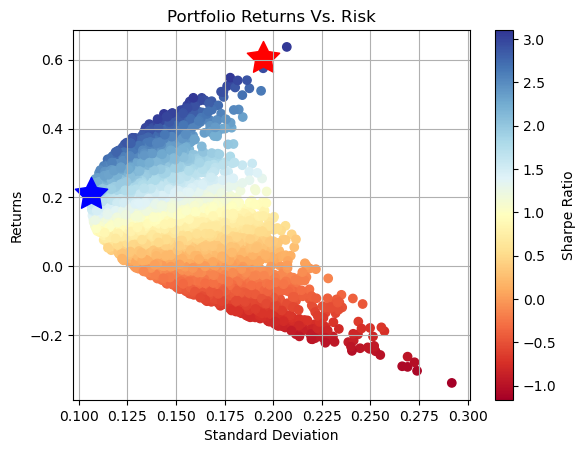

In [37]:
# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)
plt.grid()
# Finally, show the plot.
plt.show()